In [1]:
import numpy as np
from matplotlib import pyplot as plt

We have a boundary value problem:
$$
    y^{''} - y^{'} = 0, ~~y(0) = -1,  ~~y^{'}(1) - y(1) = 2    
$$


Let's solve this very complicated task in two numerical methods:
 - Shooting method
 - Grid method


# Shooting method

In [28]:
def dSdx(x, S):
    y, v = S
    return np.array([v, v])

y0 = -1
x0 = 0
h = 0.001

In [34]:
def runge_kutta(x0, y0, x, h, dF):
    n = (int)((x - x0)/h)
    y = np.copy(y0)
    for i in range(1, n + 1):
        
        k1 = h * dF(x0, y)
        k2 = h * dF(x0 + 0.5 * h, y + 0.5 * k1)
        k3 = h * dF(x0 + 0.5 * h, y + 0.5 * k2)
        k4 = h * dF(x0 + h, y + k3)

        y = y + (1.0 / 6.0)*(k1 + 2 * k2 + 2 * k3 + k4)
 
        x0 = x0 + h
    return y
 

In [35]:
def calc_F(alpha, h):
    S0 = np.array([y0, alpha])

    y = runge_kutta(x0, S0, 1, h, dSdx)[0]
    y_prev = runge_kutta(x0, S0, 1 - h, h, dSdx)[0]
    y_der = (y - y_prev) / h

    F = y_der - y - 2

    return F

def find_root(a, b, h, epsilon):
    x = a
    while x < b:
        root = newtons_method(a, b, x, h, epsilon)
        if root != -1:
            return root
        x += h
    return -1

def newtons_method(a, b, x_0, h, epsilon):
    x_prev = x_0

    F = calc_F(x_0, h)
    F_der = (F - calc_F(x0 - h, h)) / h

    x = x_0 - F / F_der
    while abs(x - x_prev) >= epsilon:
        x_prev = x

        F = calc_F(x, h)
        F_der = (F - calc_F(x - h, h)) / h
        
        x -= F / F_der
        
        if x < a or x > b:
            return -1
    return x

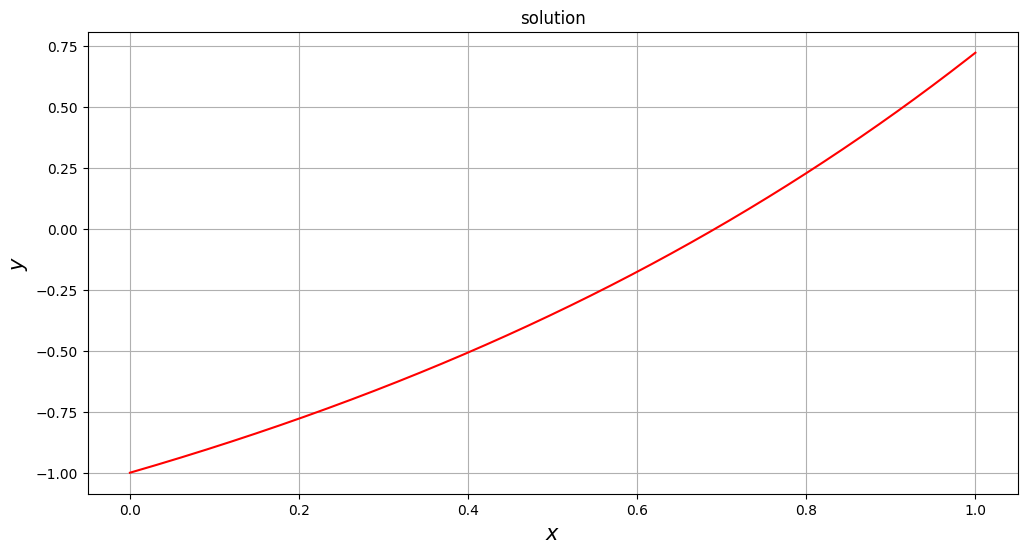

In [31]:
a = 0
b = 10
epsilon = 0.0001

alpha = find_root(a, b, h, epsilon)

S = np.array([y0, alpha])
y = []
x = np.arange(0, 1.001, 0.001)

for i in x:
    y.append(runge_kutta(x0, S, i, h, dSdx))

y = np.array(y)

plt.figure(figsize = (12,6))
plt.plot(x, y.T[0], 'r')
plt.title(r'solution')
plt.xlabel(r'$x$', fontsize = 15)
plt.ylabel(r'$y$', fontsize = 15)
plt.grid(True)

In [29]:
alpha

1.0013605365251395

# Grid method

In [5]:
def p(x):
    return -1

def q(x):
    return 0

def f(x):
    return 0

In [9]:
def calc_matrix(x, h, params):
    alpha1, alpha2, betha1, betha2, gamma1, gamma2 = params
    n = len(x) - 1
    A = np.zeros((n+1, n+1))
    f_col = np.zeros(n+1)

    A[0, 0] = alpha1 - betha1/h
    A[0, 1] = betha1/h
    A[n, n] = alpha2 + betha2/h
    A[n, n-1] = -betha2/h

    f_col[0] = gamma1
    f_col[n] = gamma2

    for i in range(1, n):
        A[i, i] = h**2 * q(x[i]) - 2
        A[i, i-1] = 1 - p(x[i]) * h / 2
        A[i, i+1] = 1 + p(x[i]) * h / 2

        f_col[i] = h**2 * f(x[i])

    return (A, f_col)


In [8]:
def swap_lines(A, f, i, k):
    temp = np.copy(A[i])
    A[i] = np.copy(A[k])
    A[k] = np.copy(temp)
    temp2 = np.copy(f[i])
    f[i] = np.copy(f[k])
    f[k] = np.copy(temp2)

def max_in_col(A, k, iter):
    max = -10
    num = -1
    size = np.size(A[0])
    for i in range(iter, size):
        if A[i, k] > max:
            num = i
            max = A[i, k]
    return num
           
def step(A, f, iter):
    size = np.size(A[0])
    num = max_in_col(A, iter, iter)
    swap_lines(A, f, iter, num)
    for i in range(0, size):
        if(i == iter):
            continue
        temp = (A[i, iter] / A[iter, iter]) * np.copy(A[iter])
        #print(temp)
        temp2 = (A[i, iter] / A[iter, iter]) * np.copy(f[iter])
        A[i] = A[i] - temp
        #print(A[i])
        f[i] = f[i] - temp2


def solve_gauss(A, f):
    size = np.size(A[0])
    for i in range(0, size):
        step(A, f, i)
    solution = np.array([f[i] / A[i, i] for i in range(0, size)])
    return solution
    

In [11]:
x = np.arange(0, 1.001, 0.001)

A, f_col = calc_matrix(x, h, (1, -1, 0, 1, -1, 2))


In [12]:
sol_y = solve_gauss(A, f_col)

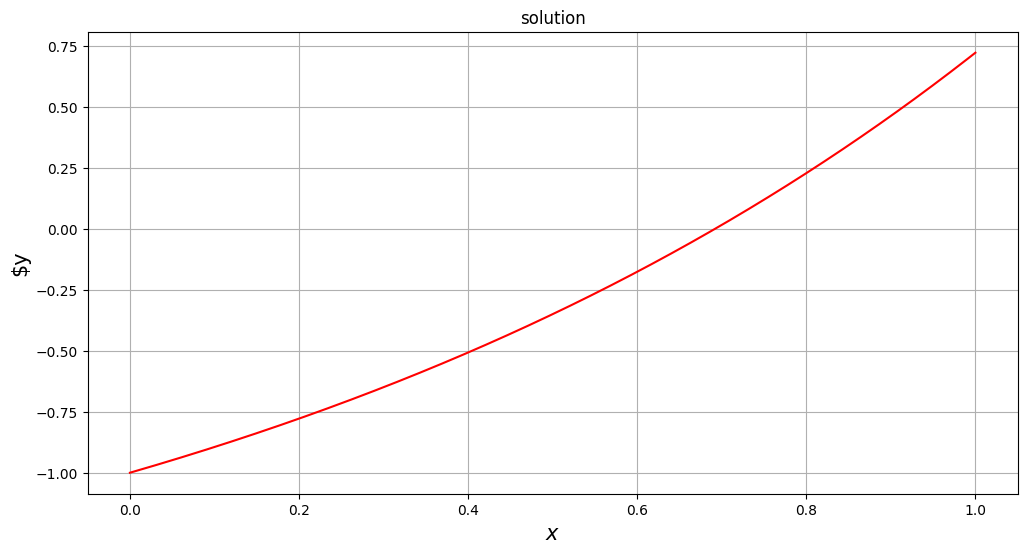

In [13]:
plt.figure(figsize = (12,6))
plt.plot(x, sol_y, 'r')
plt.title(r'solution')
plt.xlabel(r'$x$', fontsize = 15)
plt.ylabel(r'$y', fontsize = 15)
plt.grid(True)

In [14]:
def solution(x):
    return -2 + np.exp(x)

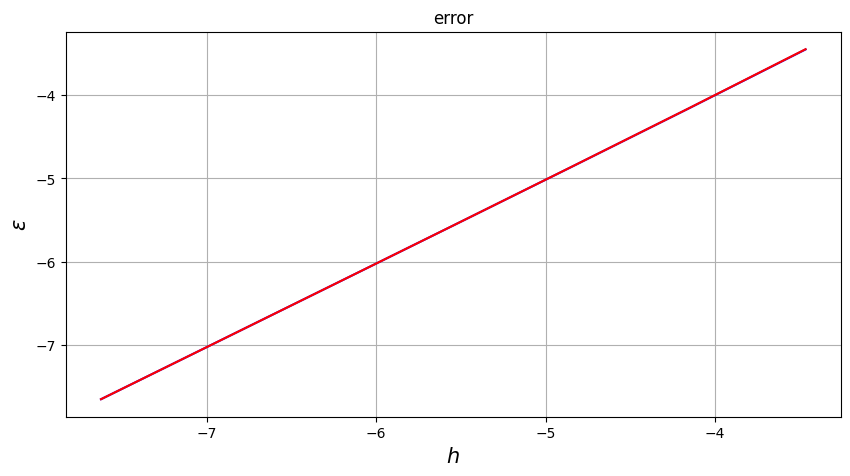

In [38]:
h  = [1/(2**i) for i in range(5, 12)]
error_grid = []
error_shoot = []

for h_i in h:
    x = np.arange(0, 1 + h_i, h_i)

    A, f_col = calc_matrix(x, h_i, (1, -1, 0, 1, -1, 2))
    num_sol_y_grid = solve_gauss(A, f_col)

    a = 0
    b = 2
    epsilon = h_i / 10
    alpha = find_root(a, b, h_i, epsilon)

    S = np.array([y0, alpha])
    num_sol_y_shoot = []

    for i in x:
        num_sol_y_shoot.append(runge_kutta(x0, S, i, h_i, dSdx))

    num_sol_y_shoot = np.array(num_sol_y_shoot).T[0]


    real_sol_y = np.array([solution(i) for i in x])

    error_grid.append(np.mean(np.abs(real_sol_y - num_sol_y_grid)))
    error_shoot.append(np.mean(np.abs(real_sol_y - num_sol_y_shoot)))

error_grid_ln = np.log(error_grid)
error_shoot_ln = np.log(error_shoot)
h_ln = np.log(h)

plt.figure(figsize = (10,5))
plt.plot(h_ln, error_grid_ln, 'b', h_ln, error_shoot_ln, 'r')
plt.title(r'error')
plt.xlabel(r'$h$', fontsize = 15)
plt.ylabel(r'$\epsilon$', fontsize = 15)
plt.grid(True)
plt.show()    